In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision

from torch.utils.data import Dataset

In [2]:
## Necessary Parameters

batch_size = 512
epochs = 20
learning_rate = 1e-4

In [3]:
# training and test dataset

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [4]:
def noise_input(images, NOISE_RATIO):
    return images * (1 - NOISE_RATIO) + torch.rand(images.size()) * NOISE_RATIO

In [5]:
class noisyMNISTDataset(Dataset):
    def __init__(self, dataset, NOISE_RATIO):
        self.dataset = dataset
        self.NOISE_RATIO = NOISE_RATIO

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        img, label = self.dataset[index]
        noisy_img = noise_input(img, NOISE_RATIO=self.NOISE_RATIO)
        noisy_img, img = noisy_img.view(-1), img.view(-1)
        return noisy_img, img
    
noisy_train_dataset = noisyMNISTDataset(train_dataset, NOISE_RATIO=0.25)
train_loader = torch.utils.data.DataLoader(
    noisy_train_dataset, batch_size=batch_size, shuffle=True
)

In [6]:
class denoisingAutoEncoder(nn.Module):
    def __init__(self,input_dim):
        super(denoisingAutoEncoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(input_dim*0.5)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.5), int(input_dim*0.25)),
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(int(input_dim*0.25), int(input_dim*0.5)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.5), input_dim),
            nn.Sigmoid()  # Sigmoid activation to squash output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
model = denoisingAutoEncoder(input_dim=784)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [8]:
def training_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    total_loss = 0
    num_batches = len(dataloader)

    model.train()  # Set model to training mode

    for batch, (X, y) in enumerate(dataloader):
        X, y = X, y  # Move data to the device (GPU/CPU)

        # Forward pass
        yhat = model(X)
        loss = loss_fn(yhat, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 100 == 0:
            current = batch * len(X)
            # print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / num_batches
    print(f"Avg loss over epoch: {avg_loss:>.7f}")

    return avg_loss


In [9]:
train_losses = []

for t in range(epochs):
    train_losses.append(training_loop(train_loader, model, loss_fn, optimizer))
    torch.save(model.state_dict(), 'model_weights.pth')
print("Done!")

Avg loss over epoch: 0.1189624
Avg loss over epoch: 0.0684891
Avg loss over epoch: 0.0630797
Avg loss over epoch: 0.0548749
Avg loss over epoch: 0.0468573
Avg loss over epoch: 0.0407275
Avg loss over epoch: 0.0369016
Avg loss over epoch: 0.0331733
Avg loss over epoch: 0.0299971
Avg loss over epoch: 0.0278270
Avg loss over epoch: 0.0258623
Avg loss over epoch: 0.0240325
Avg loss over epoch: 0.0225804
Avg loss over epoch: 0.0213973
Avg loss over epoch: 0.0202956
Avg loss over epoch: 0.0194192
Avg loss over epoch: 0.0186633
Avg loss over epoch: 0.0179284
Avg loss over epoch: 0.0172095
Avg loss over epoch: 0.0165290
Done!


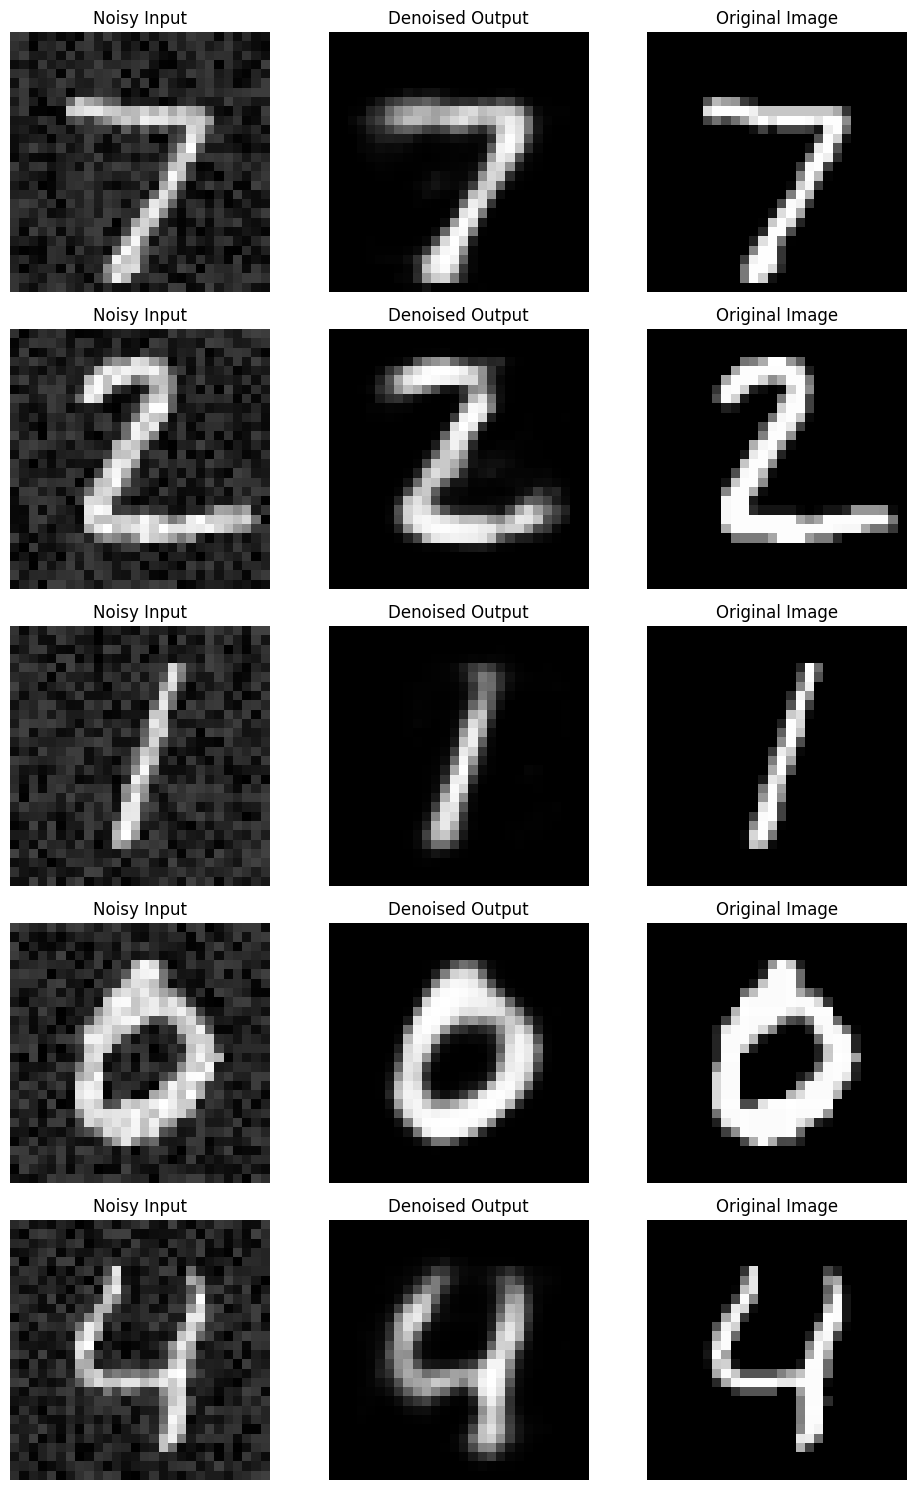

In [11]:
import matplotlib.pyplot as plt

def visualize_examples(dataloader, model, num_examples=5):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        # Get one batch of data
        for noisy_imgs, clean_imgs in dataloader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

            # Forward pass through the model to get denoised outputs
            denoised_imgs = model(noisy_imgs)

            # Convert tensors to NumPy arrays for plotting
            noisy_imgs = noisy_imgs.view(-1, 28, 28).cpu().numpy()
            denoised_imgs = denoised_imgs.view(-1, 28, 28).cpu().numpy()
            clean_imgs = clean_imgs.view(-1, 28, 28).cpu().numpy()

            # Plot the first `num_examples` images
            fig, axes = plt.subplots(num_examples, 3, figsize=(10, num_examples * 3))
            for i in range(num_examples):
                # Plot noisy image
                axes[i, 0].imshow(noisy_imgs[i], cmap="gray")
                axes[i, 0].set_title("Noisy Input")
                axes[i, 0].axis("off")

                # Plot denoised image
                axes[i, 1].imshow(denoised_imgs[i], cmap="gray")
                axes[i, 1].set_title("Denoised Output")
                axes[i, 1].axis("off")

                # Plot original clean image
                axes[i, 2].imshow(clean_imgs[i], cmap="gray")
                axes[i, 2].set_title("Original Image")
                axes[i, 2].axis("off")

            plt.tight_layout()
            plt.show()
            break  

# Test dataset and dataloader
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)
noisy_test_dataset = noisyMNISTDataset(test_dataset, NOISE_RATIO=0.25)
test_loader = torch.utils.data.DataLoader(
    noisy_test_dataset, batch_size=16, shuffle=False
)

visualize_examples(test_loader, model, num_examples=5)
